Make the CIV plot, but this time also include the 388/8403 color-selected that overlapped with the LOFAR footprint (Shimwell+2019).

Note that we need to divide our EW values by 1+z to match Amy's

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import richardsplot
import sklearn
from sklearn.preprocessing import scale
from scipy.stats import gaussian_kde
%matplotlib inline
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1638*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label="VLA Detections")

----

Load in data for 50 VLA objects.  Going to need the following:

- 3-GHz flux densities (they're 1.4-GHz for the two FIRST sources) to be converted to $L_\mathrm{3GHz}$
- $M_i(z=2)$ for the one Harris SFR relation
- EW for the other SFR relation
- C$_\mathrm{IV}$ EW/blueshift to place the quasars in that space

In [4]:
vla = pd.read_csv("../SpringFinalFigs_moreParams.csv")
vla.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,...,ICA_CIV_EQW_new2021,RM_DIST_UNSCALE,RM_DIST_SCALE,CIV_BLUESHIFT_SCALED,CIV_EQW_SCALED,CIVBestfit_Index,L3GHz [W/Hz],CIV_DIST_021721,CIV_DIST_041921,CIV_DIST_FINAL
0,0,0,0,0,0,0,0,0,0,0,...,35.900650,1728.413701,3.486256,0.722760,-0.879689,275801.0,24.469498,3.506315,2.792875,0.662801
1,1,1,1,1,1,1,1,1,1,1,...,33.912371,414.691980,2.589969,-0.319656,-0.943523,238121.0,24.841584,2.618358,2.230519,0.542545
2,2,2,2,2,2,2,2,2,2,2,...,34.648832,646.782974,2.704445,-0.134167,-0.920323,244881.0,23.606351,2.734290,2.304035,0.560694
3,3,3,3,3,3,3,3,3,3,3,...,43.720855,796.239578,2.635625,-0.014596,-0.653142,240918.0,23.761645,2.685961,2.164442,0.536344
4,4,4,4,4,4,4,4,4,4,4,...,36.524054,1490.190560,3.289717,0.534205,-0.861619,269740.0,23.545828,3.312861,2.652129,0.636308


In [5]:
S3 = vla[["int_flux"]].values.flatten()
z_vla = vla[["redshift_1"]].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z_vla)
L14_vla = radluminosity(1.4, 3., S3, -0.7, z_vla)
det_vla = vla[["detection"]].values.flatten()
F_vla = vla[['FIRST']].values.astype("int").flatten()
D_vla = det_vla+F_vla
ew_vla_old = vla[["ICA_CIV_EQW"]].values.flatten() / (1+z_vla)
ew_vla = vla[["ICA_CIV_EQW_new2021"]].values.flatten()
voff_vla = vla[["ICA_CIV_BLUESHIFT"]].values.flatten()
Mi_vla = vla[["MI_Z2_1"]].values.flatten()

#Star formation rates from Harris/Yun
avgSFR_vla = (SFR_Mi(Mi_vla) + SFR_eqw(ew_vla)) / 2.
SFRL14_vla = SFR_L14(L14_vla)

#Compare with catalog values to see what's going on
voff_cat = vla[["VOFF_CIV_PEAK_1"]].values.flatten()
ew_cat = vla[["EW_CIV_1"]].values.flatten()

#Check colors too
del_gi_vla = vla[["DELTA_G_I"]].values.flatten()

In [6]:
(min(SFR_Mi(Mi_vla)), max(SFR_Mi(Mi_vla))), (min(SFR_eqw(ew_vla)), max(SFR_eqw(ew_vla)))

((490.4012388740848, 619.5506235722751),
 (187.71990725440548, 1688.9110938581705))

In [7]:
ew_vla

array([35.9006503 , 33.91237092, 34.64883249, 43.72085485, 36.52405378,
       29.90039359, 29.07294342, 45.31849339, 40.90925044, 53.98543894,
       35.98311431, 49.96702598, 39.20673536, 11.28103408, 38.9500027 ,
       46.89522129, 66.30112544, 35.46621437, 58.24596226, 34.02555743,
       44.13728324, 31.36194158, 41.34545735, 22.08113974,  4.34668823,
       35.99037786, 54.68295954, 39.14607423, 66.48202028, 12.82696676,
       36.04872717, 36.44910452, 46.96374988, 19.27769608, 45.88503138,
       57.95910161, 36.97932907, 58.06218923, 58.38693783, 34.18775715,
       56.547089  , 48.10386397, 38.34176862, 30.60961854, 38.46635612,
       16.68684538, 36.05874184, 44.09272695, 50.53085867, 33.97779036])

Now load in parent sample that is in LOFAR footprint

In [8]:
lofar = pd.read_csv("LOFAR_from8403colorselected_all388_CIV.csv")
lofar.sort_values("name", inplace=True)
good = lofar[["good"]].values.flatten()
lofar_det = pd.read_csv("LOFAR_from8403colorselected_detections123_1arcsec.csv")
lofar_det.sort_values("name", inplace=True)
lofar_det.head()

,col1,name,RA_1,Dec_1,Source_Name,RA_2,E_RA,E_RA_tot,DEC_2,E_DEC,...,E_DC_Min,PA,E_PA,DC_PA,E_DC_PA,Isl_rms,S_Code,Mosaic_ID,Isl_id,Separation
15,2206,105245.64+463831.2,163.190206,46.642011,ILTJ105245.70+463830.7,163.190427,0.362932,0.375567,46.641878,0.244608,...,0.540513,106.081950,17.744264,106.081950,17.744264,0.066047,S,P3Hetdex16,5113,0.727160
3,1830,110039.04+510902.3,165.162686,51.150642,ILTJ110039.05+510902.2,165.162688,0.136256,0.156984,51.150616,0.144476,...,0.317960,20.380242,55.903120,20.380242,55.903120,0.067429,S,P4Hetdex16,2296,0.093947
16,2208,110429.51+481637.7,166.122993,48.277147,ILTJ110429.52+481638.0,166.123006,0.435098,0.477744,48.277241,0.259278,...,0.608496,93.276007,21.126713,0.000000,21.126713,0.054989,S,P6,2649,0.341448
4,1832,110853.98+522337.9,167.224924,52.393875,ILTJ110853.96+522337.6,167.224854,0.486835,0.516670,52.393796,0.299093,...,0.700402,84.536970,24.364421,0.000000,24.364421,0.075898,S,P8Hetdex,4605,0.324757
116,8286,111026.20+502403.6,167.609208,50.401021,ILTJ111026.21+502403.8,167.609224,0.490326,0.528534,50.401070,0.292486,...,0.683511,96.225524,27.350117,0.000000,27.350117,0.062552,S,P6,734,0.181365


In [9]:
name = lofar[["name"]].values.flatten() #can use this to pick out detections from Amy's file
name_det = lofar_det[["name"]].values.flatten()
D_lofar = np.array([])
for i in range(len(name)):
    if (name[i]==name_det).any():
        D_lofar = np.append(D_lofar, True)
    else:
        D_lofar = np.append(D_lofar, False)

det_lofar = (D_lofar==1.)

In [10]:
len(det_lofar)#.sum()

388

Good, we have a mask for all the detections in LOFAR

In [11]:
S144 = 210.*np.ones(len(lofar)) #initialize all objects to non-detections
S144[det_lofar] = lofar_det[["Total_flux"]].values.flatten() * 1.e3
z_lofar = lofar[["z_paul"]].values.flatten()
L3_lofar = radluminosity(3., 0.144, S144, -0.7, z_lofar)
L14_lofar = radluminosity(1.4, 0.144, S144, -0.7, z_lofar)
ew_lofar = lofar[["CIV_EW"]].values.flatten()
voff_lofar = lofar[["CIV_blue"]].values.flatten()
Mi_lofar = lofar[["MI_Z2"]].values.flatten()
del_gi_lof = lofar[["DELTA_G_I"]].values.flatten()

#Star formation rates from Harris/Yun
avgSFR_lof = (SFR_Mi(Mi_lofar) + SFR_eqw(ew_lofar)) / 2.
SFRL14_lof = SFR_L14(L14_lofar)

In [17]:
fit = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/bestfit.npy")[10000:51500,:]
vla_dist = vla[["CIV_DIST_FINAL"]].values.flatten() 
lof_dist = lofar[["CIV_DIST_FINAL"]].values.flatten()

In [18]:
max(del_gi_vla)-min(del_gi_vla), max(del_gi_lof)-min(del_gi_lof)

(0.8315814866655311, 1.7357318560713333)

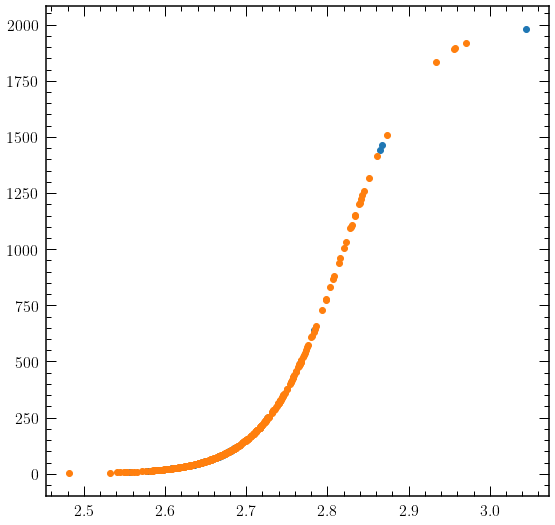

In [19]:
#Star formation rates from Harris/Yun

#The standard size scaling for these plots -
#Determination of this scaling happened in Trevor's version of "CIV_plot_GTR_fixed.ipynb"
#sent to GTR and AEK through the e-mail thread "VLA Paper" on 9/3/2020 at 5:05 PM

plt.figure(figsize=(9,9))

A = 0. #lower asymptote
K = 2000. #upper asymptote
B = 21. #growth rate -- the bigger this is, the quicker you reach the upper asymptote
nu = 1. #affects where the max growth occurs
Q = 1199. #bigger Q returns a smaller starting size 

sharris_vla = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR_lof)))))**(1/nu)) for i in np.log10(avgSFR_vla)])
syun_vla = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(SFRL14_vla)))))**(1/nu)) for i in np.log10(SFRL14_vla)])

sharris_lof = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR_lof)))))**(1/nu)) for i in np.log10(avgSFR_lof)])
syun_lof = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(SFRL14_lof)))))**(1/nu)) for i in np.log10(SFRL14_lof)])

plt.scatter(np.log10(avgSFR_vla), sharris_vla)
plt.scatter(np.log10(avgSFR_lof), sharris_lof)

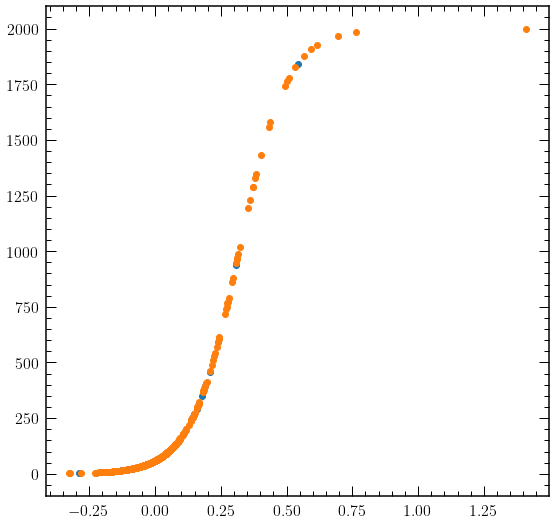

In [20]:
#Try to make approximately the same scale as above for del(g-i)
plt.figure(figsize=(9,9))

A = 0. #lower asymptote
K = 2000. #upper asymptote
B = 11. #growth rate -- the bigger this is, the quicker you reach the upper asymptote
nu = 1. #affects where the max growth occurs
Q = 1199. #bigger Q returns a smaller starting size 

sdgi_vla = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(min(del_gi_vla), min(del_gi_lof)))))**(1/nu)) for i in del_gi_vla])
sdgi_lof = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(min(del_gi_vla), min(del_gi_lof)))))**(1/nu)) for i in del_gi_lof])

plt.scatter(del_gi_vla, sdgi_vla)
plt.scatter(del_gi_lof, sdgi_lof)

In [21]:
#get the index of the point closest to Delta(g-i)=0
s0 = sdgi_lof[abs(del_gi_lof).argmin()]
s0

58.73761736606045

In [22]:
first = pd.read_csv("lofar_first_quasars.csv")

In [23]:
#Want a mask that picks out FIRST detections from our LOFAR sources
lof = lofar[["name"]].values.flatten()
fir = first[["name"]].values.flatten()
lof.sort(), fir.sort()
lofar_1st = np.array([])

for i in range(len(lof)):
    if (lof[i]==fir).any():
        lofar_1st = np.append(lofar_1st, True)
    else:
        lofar_1st = np.append(lofar_1st, False)

first_lofar = (lofar_1st==1.)

----

In the below plots, I want to add the lines dividing our three CIV regions.  The below code may not make much sense, but see ``/Users/trevormccaffrey/Desktop/Research/GTR/VLA2018b/LOFAR/CIVPlot_wLOFAR_final.ipynb`` for more of a "walkthrough".

In [24]:
#Get dashed lines to draw above - see CIVPlot_wLOFAR_final_finalCIVdist.ipynb
CIV_0p50 = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.50.npy")
m_50, b_50 = np.polyfit(10.**CIV_0p50[:,1], CIV_0p50[:,0], 1)
x_50 = np.arange(37, 69, 1)

CIV_0p75 = np.load("/Users/trevormccaffrey/Desktop/git/CIV_Distance/data/const_civdist_arrs/CIVdist_eq_0.75.npy")
m_75, b_75 = np.polyfit(10.**CIV_0p75[:,1], CIV_0p75[:,0], 1)
x_75 = np.arange(2, 40, 1)

y_50 = m_75*x_50 + b_50
y_75 = m_50*x_75 + b_75

-----

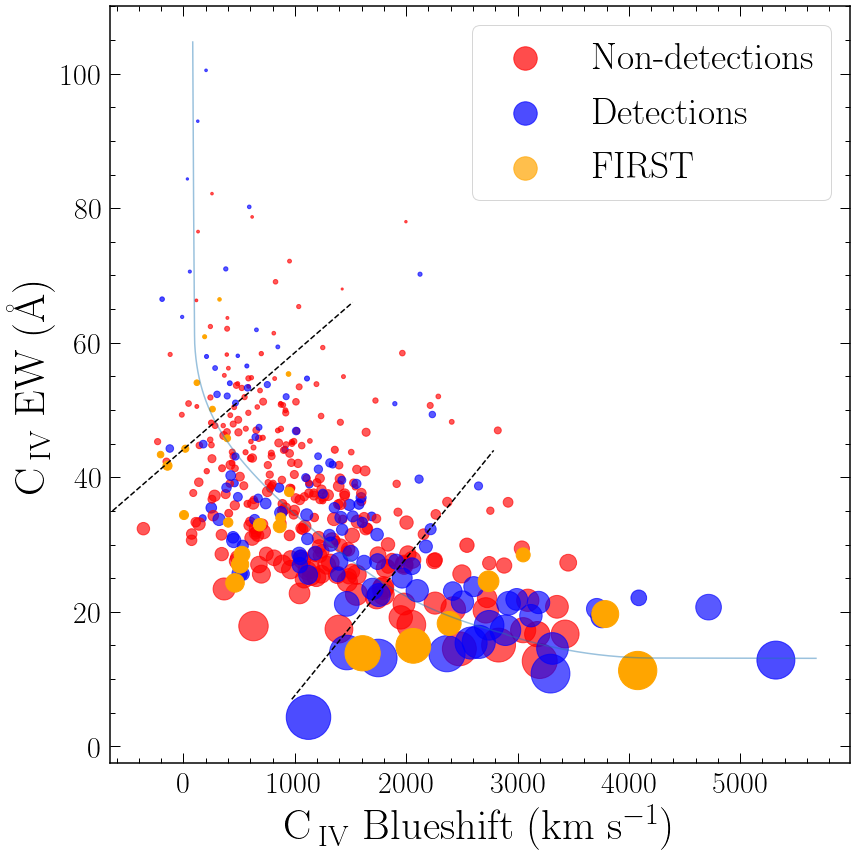

In [42]:
fig, ax1 = plt.subplots(figsize=(12,12))

#Plot the best-fit line
ax1.plot(fit[:,0], 10.**fit[:,1], alpha=0.45)

ax1.scatter(voff_vla[D_vla==0], ew_vla[D_vla==0], s=sharris_vla[D_vla==0], color="red", alpha=0.7)
ax1.scatter(voff_vla[D_vla==1], ew_vla[D_vla==1], s=sharris_vla[D_vla==1], color="blue", alpha=0.7)
ax1.scatter(voff_vla[D_vla==2], ew_vla[D_vla==2], s=sharris_vla[D_vla==2], color="orange", alpha=1.0, zorder=2)

#Plot the LOFAR data
ax1.scatter(voff_lofar[~det_lofar&good&~first_lofar], ew_lofar[~det_lofar&good&~first_lofar], 
            s=sharris_lof[~det_lofar&good&~first_lofar], color="r", alpha=0.65)
ax1.scatter(voff_lofar[det_lofar&good&~first_lofar], ew_lofar[det_lofar&good&~first_lofar], 
            s=sharris_lof[det_lofar&good&~first_lofar], color="b", alpha=0.65)
ax1.scatter(voff_lofar[det_lofar&good&first_lofar], ew_lofar[det_lofar&good&first_lofar], 
            s=sharris_lof[det_lofar&good&first_lofar], color="orange", alpha=1.0)

#Faux points so they're the same size in the legend
#ax1.scatter(5000, 5000, s=550, color=colors[0], alpha=0.2, label="Control")
ax1.scatter(5000, 5000, s=550, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, s=550, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, s=550, color="orange", alpha=0.7, label="FIRST")

ax1.plot(y_50-1200, x_50-2, "--k")
ax1.plot(y_75+900, x_75+5, "--k")

ax1.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=42.5)
ax1.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=42.5)
ax1.set_xlim(-661.8514413771277, 5982.474755356233)
ax1.set_ylim(-2.5,110)
#ax1.legend(loc="best", bbox_to_anchor=(0.64,0.21), prop={'size': 23.5})
ax1.legend(loc="best", prop={'size': 37.5})
ax1.tick_params(axis='both', which='major', labelsize=30)
#ax1.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_sizeHarris_SFRinset.pdf")
plt.savefig("../PaperPlots/fig5Anew.pdf")
#plt.savefig("PaperPlots/CIVPlot_sizeHarris.pdf")
plt.show()

Make version of the above plot coded with del(g-i)

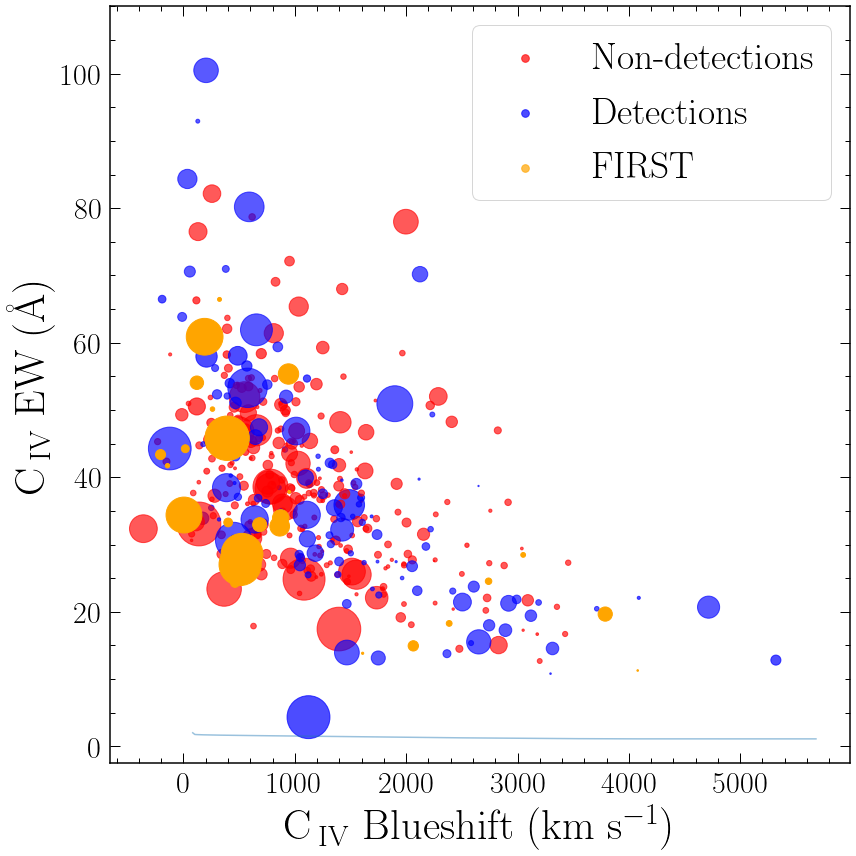

In [40]:
fig, ax1 = plt.subplots(figsize=(12,12))

#Plot the best-fit line
ax1.plot(fit[:,0], fit[:,1], alpha=0.45)

ax1.scatter(voff_vla[D_vla==0], ew_vla[D_vla==0], s=sdgi_vla[D_vla==0], color="red", alpha=0.7)
ax1.scatter(voff_vla[D_vla==1], ew_vla[D_vla==1], s=sdgi_vla[D_vla==1], color="blue", alpha=0.7)
ax1.scatter(voff_vla[D_vla==2], ew_vla[D_vla==2], s=sdgi_vla[D_vla==2], color="orange", alpha=1.0, zorder=2)

#Plot the LOFAR data
ax1.scatter(voff_lofar[~det_lofar&good&~first_lofar], ew_lofar[~det_lofar&good&~first_lofar], 
            s=sdgi_lof[~det_lofar&good&~first_lofar], color="r", alpha=0.65)
ax1.scatter(voff_lofar[det_lofar&good&~first_lofar], ew_lofar[det_lofar&good&~first_lofar], 
            s=sdgi_lof[det_lofar&good&~first_lofar], color="b", alpha=0.65)
ax1.scatter(voff_lofar[det_lofar&good&first_lofar], ew_lofar[det_lofar&good&first_lofar], 
            s=sdgi_lof[det_lofar&good&first_lofar], color="orange", alpha=1.0)

#Faux points so they're the same size in the legend
#ax1.scatter(5000, 5000, s=550, color=colors[0], alpha=0.2, label="Control")
ax1.scatter(5000, 5000, s=s0, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, s=s0, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, s=s0, color="orange", alpha=0.7, label="FIRST")

ax1.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=42.5)
ax1.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=42.5)
#ax1.set_xlim(-800,5800)
ax1.set_ylim(-2.5,110)
#ax1.legend(loc="best", bbox_to_anchor=(0.64,0.21), prop={'size': 23.5})
ax1.legend(loc="best", prop={'size': 37.5})
ax1.tick_params(axis='both', which='major', labelsize=30)
#ax1.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_sizeHarris_SFRinset.pdf")
#plt.savefig("../PaperPlots/fig6A.pdf")
#plt.savefig("PaperPlots/CIVPlot_sizeHarris.pdf")
plt.show()

Same thing as just above, but make all points the same size and color-code points based on Delta(g-i)

In [29]:
ew_lofar.shape

(388,)

In [30]:
dlof = np.array([voff_lofar[good], ew_lofar[good], del_gi_lof[good]]).T
dvla = np.array([voff_vla, ew_vla, del_gi_vla]).T
data = np.concatenate((dlof, dvla), axis=0)
data.shape

(428, 3)

In [31]:
np.percentile(data[:,2], 100)

0.695120008662343

In [32]:
max(data[:,2])

0.695120008662343

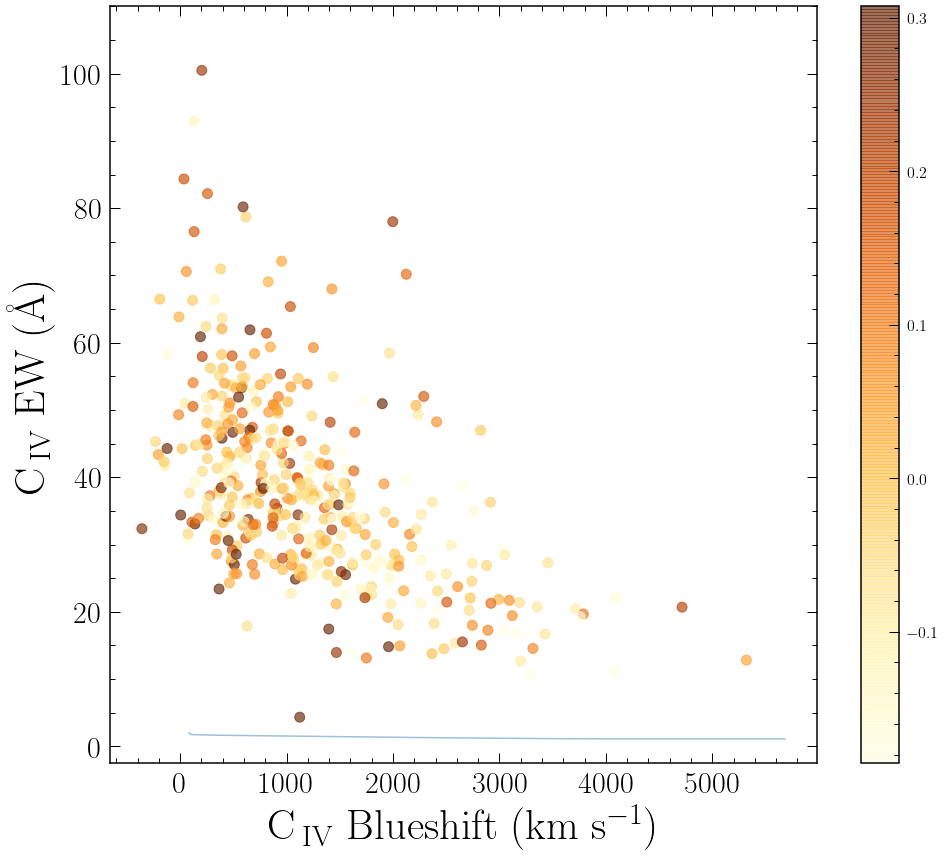

In [33]:
fig, ax1 = plt.subplots(figsize=(14,12))

cm = plt.cm.get_cmap('YlOrBr')

#Plot the best-fit line
ax1.plot(fit[:,0], fit[:,1], alpha=0.45)

#Plot the data
sc = ax1.scatter(data[:,0],data[:,1], s=100, c=data[:,2], alpha=0.65, vmin=np.percentile(data[:,2], 5), vmax=np.percentile(data[:,2], 95), cmap=cm)
plt.colorbar(sc)

ax1.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=42.5)
ax1.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=42.5)
#ax1.set_xlim(-800,5800)
ax1.set_ylim(-2.5,110)
#ax1.legend(loc="best", bbox_to_anchor=(0.64,0.21), prop={'size': 23.5})
#ax1.legend(loc="best", prop={'size': 37.5})
ax1.tick_params(axis='both', which='major', labelsize=30)
#ax1.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
#plt.savefig("PaperPlots/CIVPlot_sizeHarris_SFRinset.pdf")
#plt.savefig("../PaperPlots/fig6A.pdf")
#plt.savefig("PaperPlots/CIVPlot_sizeHarris.pdf")
plt.show()

In [34]:
D_vla

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2.])

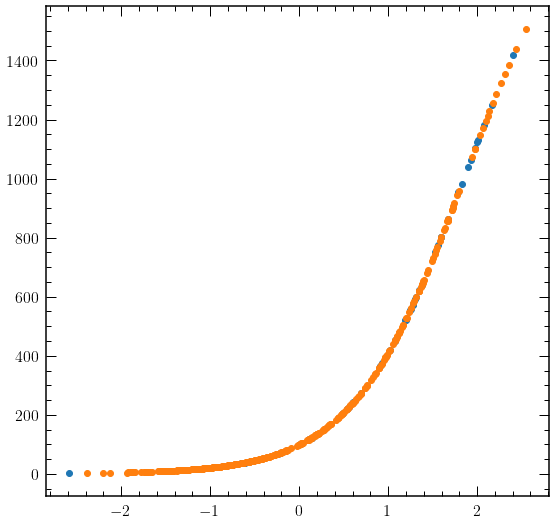

In [35]:
plt.figure(figsize=(9,9))

#For the ratio plot the scaling is different
ratio_vla = syun_vla/sharris_vla
ratio_lof = syun_lof/sharris_lof

A = 0. #lower asymptote
K = 2000. #upper asymptote
B = 1.6#growth rate -- the bigger this is, the quicker you reach the upper asymptote
nu = 1. #affects where the max growth occurs
Q = 1199. #bigger Q returns a smaller starting size 

sratio_vla = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(min(np.log10(ratio_vla)), min(np.log10(ratio_vla))))))**(1/nu)) for i in np.log10(ratio_vla)])
sratio_lof = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(min(np.log10(ratio_vla)), min(np.log10(ratio_lof))))))**(1/nu)) for i in np.log10(ratio_lof)])

plt.scatter(np.log10(ratio_vla), sratio_vla)
plt.scatter(np.log10(ratio_lof), sratio_lof)

In [36]:
#Find object closest to SFR_obs = SFR_pred
bulk_ind = np.argmin((((SFRL14_lof/avgSFR_lof)-1.)**2))
print(np.array([lofar['name'], ((SFRL14_lof/avgSFR_lof)-1.), syun_lof, sharris_lof]).T[bulk_ind])

['141151.97+550948.7' 0.0016275009335817714 27.78483534539576
 74.7142531368318]


In [37]:
#The size of non-detections will be the same as detections with SFR_obs = SFR_pred 
ndet_size = sharris_lof[bulk_ind]
ndet_size

74.7142531368318

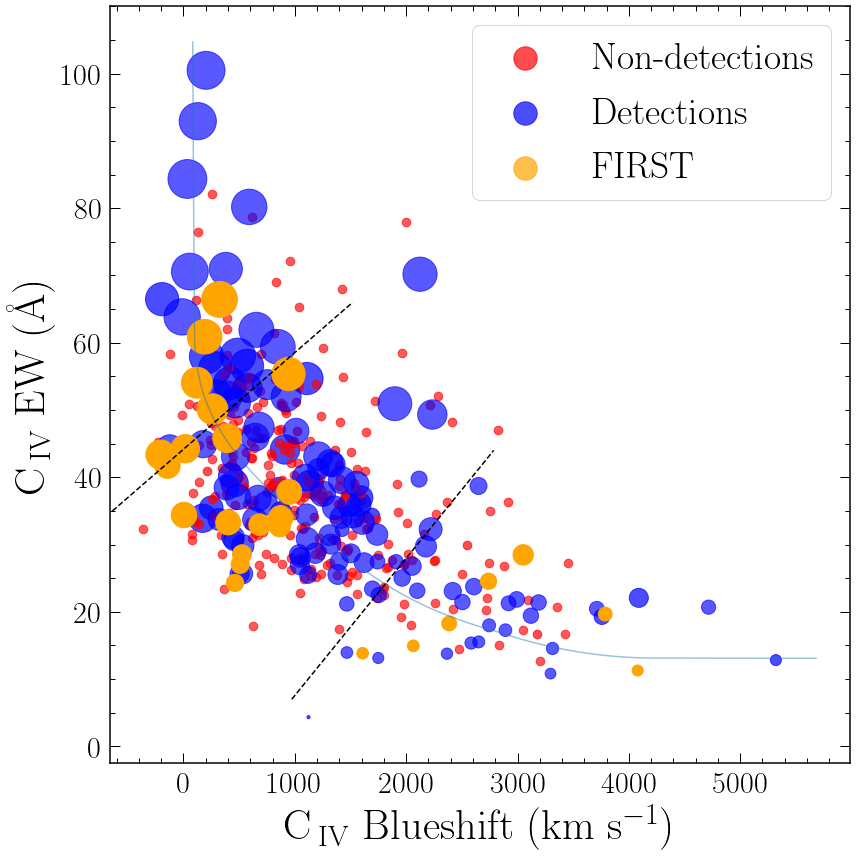

In [44]:
fig, ax1 = plt.subplots(figsize=(12,12))

#Plot the best-fit line
ax1.plot(fit[:,0], 10.**fit[:,1], alpha=0.45)

ax1.scatter(voff_vla[D_vla==0], ew_vla[D_vla==0], s=ndet_size, color="red", alpha=0.7)
ax1.scatter(voff_vla[D_vla==1], ew_vla[D_vla==1], s=sratio_vla[D_vla==1], color="blue", alpha=0.7)
ax1.scatter(voff_vla[D_vla==2], ew_vla[D_vla==2], s=sratio_vla[D_vla==2], color="orange", alpha=1.0, zorder=2)

#Plot the LOFAR data
ax1.scatter(voff_lofar[~det_lofar&good&~first_lofar], ew_lofar[~det_lofar&good&~first_lofar], 
            s=ndet_size, color="r", alpha=0.65)
ax1.scatter(voff_lofar[det_lofar&good&~first_lofar], ew_lofar[det_lofar&good&~first_lofar], 
            s=sratio_lof[det_lofar&good&~first_lofar], color="b", alpha=0.65)
ax1.scatter(voff_lofar[det_lofar&good&first_lofar], ew_lofar[det_lofar&good&first_lofar], 
            s=sratio_lof[det_lofar&good&first_lofar], color="orange", alpha=1.0)

#Faux points so they're the same size in the legend
#ax1.scatter(5000, 5000, s=550, color=colors[0], alpha=0.2, label="Control")
ax1.scatter(5000, 5000, s=550, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, s=550, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, s=550, color="orange", alpha=0.7, label="FIRST")

ax1.plot(y_50-1200, x_50-2, "--k")
ax1.plot(y_75+900, x_75+5, "--k")

ax1.set_xlabel("C\,$_\mathrm{IV}$ Blueshift (km s$^{-1}$)", fontsize=42.5)
ax1.set_ylabel("C\,$_\mathrm{IV}$ EW (Å)", fontsize=42.5)
ax1.set_xlim(-661.8514413771277, 5982.474755356233)
ax1.set_ylim(-2.5,110)
#ax1.legend(loc="best", bbox_to_anchor=(0.64,0.21), prop={'size': 23.5})
ax1.legend(loc="best", prop={'size': 37.5})
ax1.tick_params(axis='both', which='major', labelsize=30)
#ax1.tick_params(axis='both', which='minor', labelsize=8)
plt.tight_layout()
plt.savefig("../PaperPlots/fig5Bnew.pdf")
plt.show()